<a href="https://colab.research.google.com/github/Pranshu-collab/Polyp_Segmentatation_model/blob/main/Polyp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mounted the drive for images and masks
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
from PIL import Image

def load_polyp_dataset(image_dir, mask_dir, img_size=(256, 256)):

    # Loads images and masks from specified directories.
    # Args:
    #   image_dir (str): Directory containing the polyp images.
    #   mask_dir (str): Directory containing the corresponding masks.
    #   img_size (tuple): Target size for resizing images and masks.
    # Returns:
    #    tuple: A tuple containing two lists, one for images and one for masks.

    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    images = []
    masks = []

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        try:
            img = Image.open(img_path).convert('RGB')
            mask = Image.open(mask_path).convert('L') # Convert mask to grayscale

            img = img.resize(img_size)
            mask = mask.resize(img_size)
            img=np.array(img).astype(np.float32)/255.0  # normalization of pixels
            mask=(np.array(mask)>127).astype(np.float32)

            images.append(img)
            masks.append(mask[...,np.newaxis])
        except Exception as e:
            print(f"Error loading {img_file} or {mask_file}: {e}")

    return np.array(images), np.array(masks)

image_directory = '/content/drive/MyDrive/Kvasir-SEG/images'
mask_directory = '/content/drive/MyDrive/Kvasir-SEG/masks'
images, masks = load_polyp_dataset(image_directory, mask_directory)

print(f"Loaded {len(images)} images and {len(masks)} masks.")
print(f"Image shape: {images.shape}")
print(f"Mask shape: {masks.shape}")

Loaded 1000 images and 1000 masks.
Image shape: (1000, 256, 256, 3)
Mask shape: (1000, 256, 256, 1)


In [4]:
import tensorflow as tf
def get_tf_dataset(images, masks, batch_size=32, shuffle=True):
    dataset_size = len(images)
    train_size = int(0.8 * dataset_size)
    val_size = int(0.1 * dataset_size)

    # Shuffle full data
    if shuffle:
        indices = np.arange(dataset_size)
        np.random.shuffle(indices)
        images, masks = images[indices], masks[indices]

    # Split data
    train_images, val_images, test_images = np.split(images, [train_size, train_size + val_size])
    train_masks, val_masks, test_masks = np.split(masks, [train_size, train_size + val_size])

    # Create tf.data.Dataset
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
    test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_masks))

    # Batch and prefetch
    train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

In [5]:
# Image Augmentation
def augment(image, mask):
    seed = tf.random.uniform(shape=(2,), maxval=10000, dtype=tf.int32)
    image = tf.image.stateless_random_flip_left_right(image, seed)
    mask = tf.image.stateless_random_flip_left_right(mask, seed)
    return image, mask

In [6]:
# Loading the dataset and applied augmentation to train dataset
images, masks = load_polyp_dataset(image_directory, mask_directory)
train_ds, val_ds, test_ds = get_tf_dataset(images, masks, batch_size=32)
train_ds=train_ds.map(lambda x,y:augment(x,y),num_parallel_calls=tf.data.AUTOTUNE)

In [7]:
# Attention with unet
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.layers import multiply, add, Activation, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

def attention_gate(inp_1, inp_2, n_intermediate_channels):
    inp_1_conv = Conv2D(n_intermediate_channels, (1, 1), padding='same')(inp_1)
    inp_2_conv = Conv2D(n_intermediate_channels, (1, 1), padding='same')(inp_2)
    f = add([inp_1_conv, inp_2_conv])
    f = Activation('relu')(f)
    g = Conv2D(1, (1, 1), padding='same')(f)
    gate = Activation('sigmoid')(g)

    return multiply([inp_2, gate])

def conv_block(input_tensor, num_filters):
    encoder = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = Activation('relu')(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = Activation('relu')(encoder)
    encoder = BatchNormalization()(encoder)
    return encoder
def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = concatenate([decoder, concat_tensor], axis=-1)
    decoder = conv_block(decoder, num_filters)
    return decoder

def get_attention_unet(input_shape, num_filters_start=16, num_classes=1):
    inputs = Input(input_shape)

    # Downsampling through the model
    encoder_pool0, encoder0 = encoder_block(inputs, num_filters_start)
    encoder_pool1, encoder1 = encoder_block(encoder_pool0, num_filters_start*2)
    encoder_pool2, encoder2 = encoder_block(encoder_pool1, num_filters_start*4)
    encoder_pool3, encoder3 = encoder_block(encoder_pool2, num_filters_start*8)

    center = conv_block(encoder_pool3, num_filters_start*16)

    # Upsampling and establishing the skip connections
    decoder3 = decoder_block(center, encoder3, num_filters_start*8)
    attn3 = attention_gate(encoder3, decoder3, num_filters_start*8)
    decoder2 = decoder_block(attn3, encoder2, num_filters_start*4)
    attn2 = attention_gate(encoder2, decoder2, num_filters_start*4)
    decoder1 = decoder_block(attn2, encoder1, num_filters_start*2)
    attn1 = attention_gate(encoder1, decoder1, num_filters_start*2)
    decoder0 = decoder_block(attn1, encoder0, num_filters_start)
    # Output
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(decoder0)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [8]:
input_shape = (256, 256, 3)  #input dimensions
num_filters_start = 32  # number of filters in the first layer of U-Net
num_classes = 1  # binary segmentation

# Create a new model instance
attention_unet_model = get_attention_unet(input_shape, num_filters_start, num_classes)

import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

In [17]:
attention_unet_model.compile(optimizer='adam', loss=bce_dice_loss,metrics=[dice_coef,iou_coef])

# Summary of the model
attention_unet_model.summary()
plot_model(attention_unet_model, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ activation[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ activation_1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ activation_2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ activation_3[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ conv2d_4[0][0]  

 Total params: 7,945,252 (30.31 MB)

 Trainable params: 7,939,364 (30.29 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [19]:
# Training the model
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras", save_best_only=True, monitor='val_loss', mode='min'
)
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6
)
history = attention_unet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 835ms/step - dice_coef: 0.8693 - iou_coef: 0.7320 - loss: 0.1585 - val_dice_coef: 0.6958 - val_iou_coef: 0.5123 - val_loss: 0.5783 - learning_rate: 0.0010
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 652ms/step - dice_coef: 0.8645 - iou_coef: 0.7230 - loss: 0.1597 - val_dice_coef: 0.7115 - val_iou_coef: 0.5286 - val_loss: 0.8190 - learning_rate: 0.0010
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 671ms/step - dice_coef: 0.8698 - iou_coef: 0.7340 - loss: 0.1514 - val_dice_coef: 0.6883 - val_iou_coef: 0.4869 - val_loss: 1.0915 - learning_rate: 0.0010
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 749ms/step - dice_coef: 0.8772 - iou_coef: 0.7483 - loss: 0.1449 - val_dice_coef: 0.7361 - val_iou_coef: 0.5660 - val_loss: 0.5523 - learning_rate: 0.0010
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 734ms/step - dice_coef: 0.8871 - iou_coef: 0.7592 - loss: 0.1325 - val_dice_coef: 0.7621 - val_iou_coef: 0.5714 - val_loss: 0.4864 - learning_rate: 0.0010
Epoch 6/50
25/2

In [20]:
# Evaluate the model
val_loss, val_dice_coef, val_iou_coef = attention_unet_model.evaluate(val_ds)
print(f"Validation Loss: {val_loss}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - dice_coef: 0.7971 - iou_coef: 0.6577 - loss: 0.3634
Validation Loss: 0.38210219144821167


In [21]:
# Giving the validatation data to display some images
import numpy as np

X_val = []
y_val = []

for x, y in val_ds:
    X_val.append(x.numpy())
    y_val.append(y.numpy())

X_val = np.concatenate(X_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

In [22]:
import random
# X_val and y_val are validation images and masks
num_samples = 5  # number of samples to display
sample_indices = random.sample(range(len(X_val)), num_samples)

sample_images = X_val[sample_indices]
sample_true_masks = y_val[sample_indices]

sample_pred_masks = attention_unet_model.predict(sample_images)

# Thresholding example (adjust threshold as needed)
sample_pred_masks = (sample_pred_masks > 0.5).astype(np.uint8)

sample_pred_masks = attention_unet_model.predict(sample_images)

# Thresholding example (adjust threshold as needed)
sample_pred_masks = (sample_pred_masks > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


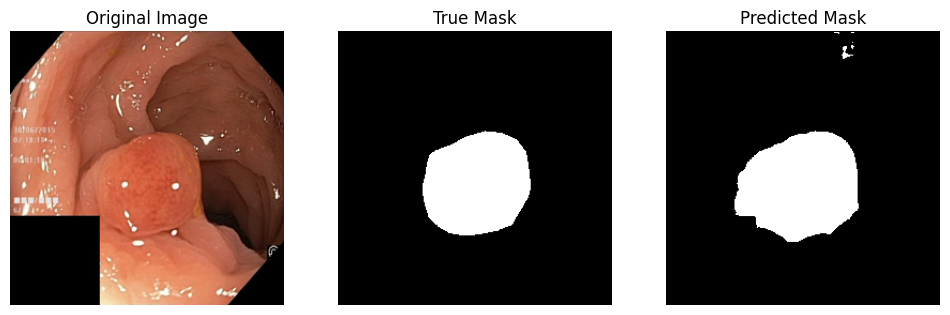

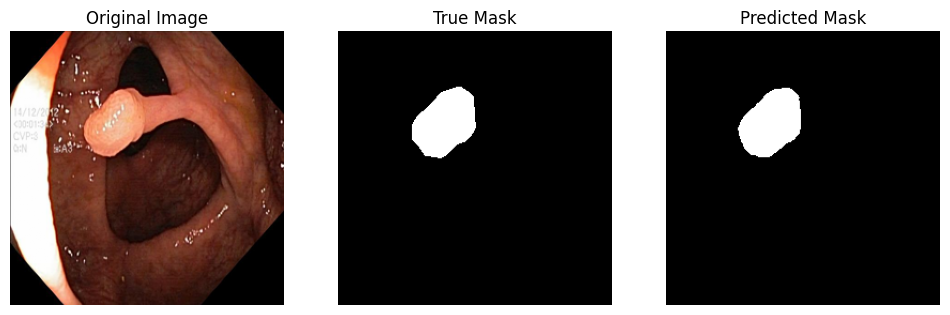

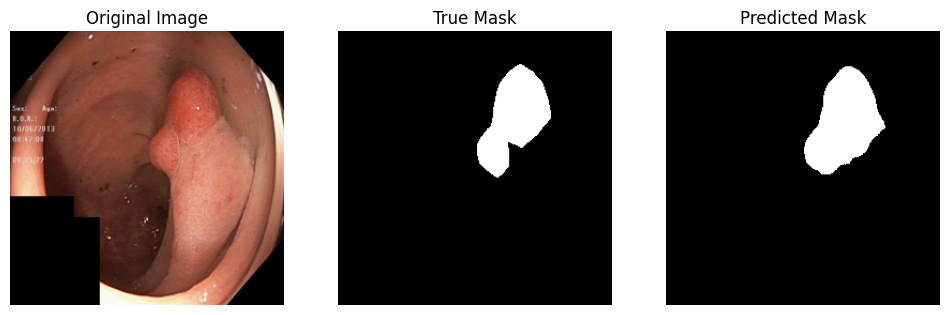

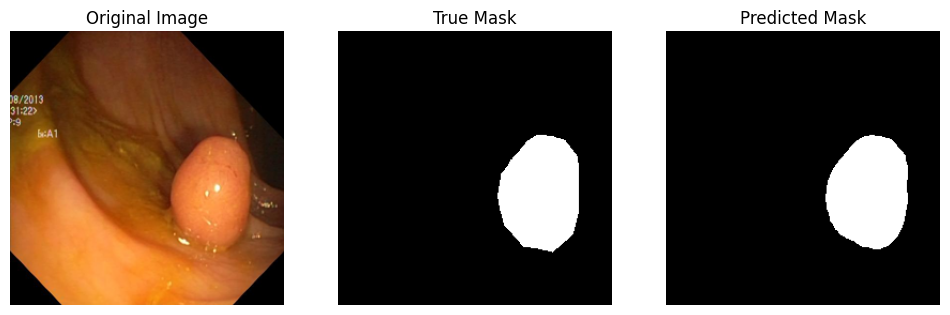

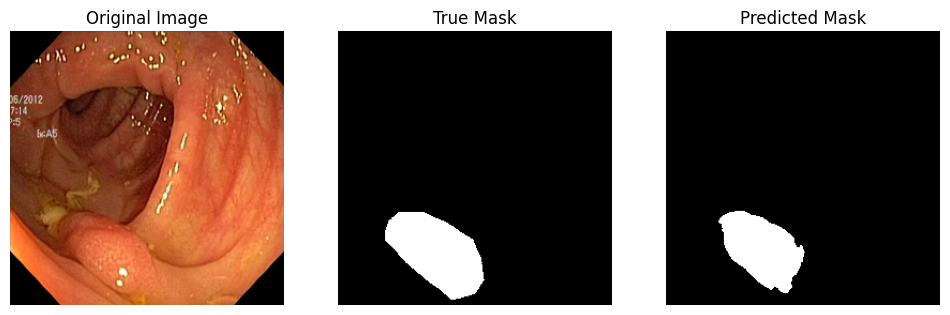

In [23]:
import matplotlib.pyplot as plt
for i in range(num_samples):
    plt.figure(figsize=(12, 5))

    # Display original image
    plt.subplot(1, 3, 1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Display true mask
    plt.subplot(1, 3, 2)
    plt.imshow(sample_true_masks[i], cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    # Display predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(sample_pred_masks[i], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.show()

In [24]:
# Evaluating the test loss
test_loss, dice, iou = attention_unet_model.evaluate(test_ds)
print(f"Dice Coefficient: {dice:.4f}")
print(f"IoU: {iou:.4f}")
print(f"test_loss: {test_loss:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - dice_coef: 0.8044 - iou_coef: 0.6588 - loss: 0.3266
Dice Coefficient: 0.7868
IoU: 0.6573
test_loss: 0.3383
